### Load basic required libraries

In [1]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re

from PIL import Image
import base64

import seaborn as sns

/home/bria/.local/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/bria/.local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/bria/.local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/bria/.local/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/home/bria/.local/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary inco

### Load VGG feature analysis libraries and scripts

In [2]:
# import torch
# import torchvision.models as models
# import torch.nn as nn
# import torchvision.transforms as transforms
# import torch.nn.functional as F
# from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/usr/local/lib/python2.7/dist-packages/sklearn/utils/extmath.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/cluster/supervised.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/pairwise.py:30: RuntimeWarning: numpy.dtype size chan

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract (mini verison of) adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png_mini' --layer_ind=6 --cohort='adult' --spatial_avg=True`

In [110]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
#     X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu
    
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    F = np.load('/home/bria/kiddraw/data/photodraw_features/FEATURES_{}_{}_Spatial_True.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('/home/bria/kiddraw/data/photodraw_features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session','condition']]
    return F, M

## apply clustering to organize RDM so that we can see some block diagonal structure
def flatten(x):
    return [item for sublist in x for item in sublist]

### Extract adult drawing features

In [111]:
layer_ind=6
KF, KM = load_features("kid",layer_ind)

In [154]:
ind = KM.index[KM['condition'] == 'S']
SM_subset =  KM.loc[ind]
SF_subset =  KF[ind.tolist()]
print 'we have {} drawings in semantic condition'.format(np.shape(SM_subset)[0])

ind2 = KM.index[KM['condition'] == 'W']
WM_subset =  KM.loc[ind2]
WF_subset =  KF[ind2.tolist()]
print 'we have {} drawings in wm condition'.format(np.shape(WF_subset)[0])

ind3 = KM.index[KM['condition'] == 'P']
PM_subset =  KM.loc[ind3]
PF_subset =  KF[ind3.tolist()]
print 'we have {} drawings in perception condition'.format(np.shape(PF_subset)[0])

we have 94 drawings in semantic condition
we have 100 drawings in wm condition
we have 95 drawings in perception condition


### Get sorting indexes for ploting RMDS

In [113]:
## retrieve alpha sorted labels from meta
_labels = np.unique(KM.label.values)
means = get_class_means(KF, KM.label.values)
af = AffinityPropagation(damping=.5).fit(means)
labels = af.labels_
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

ordered_objs = []
print('Clusters')
for k in range(n_clusters_):
    class_members = labels == k
    print _labels[class_members]
    ordered_objs.append(list(_labels[class_members]))
    
ordered_objs = np.array(flatten(ordered_objs))

# define standard order to be used for RDM's across layers
standard_order = ordered_objs

## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

Clusters
['cat' 'rabbit' 'shoe']
['cup']
['train']


In [114]:
sort_inds

[0, 2, 3, 1, 4]

### Representational Similarity Analyses

In [136]:
def get_and_plot_RDM(M,F,cohort,sort_inds,layer_ind,condition):
    ## sorted adult RDMs
    labels = M.label.values;
    means = get_class_means(F, labels);
    ordered_means = means[sort_inds,:] ## a way to sort the cateogries
    sns.set_style('white')
    corrmat = np.corrcoef(ordered_means);
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    rdm = 1-corrmat
    plt.matshow(rdm, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    plt.gcf().subplots_adjust(left=0.5) 
    plt.savefig('./plots/RDM_{}_Layer_{}_{}.pdf'.format(cohort, layer_ind,condition), bbox_inches="tight")
    return rdm

<Figure size 2160x2160 with 0 Axes>

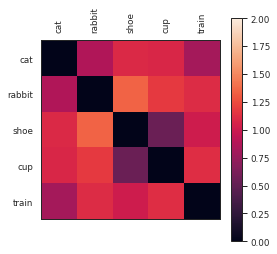

In [137]:
S_RDM = get_and_plot_RDM(SM_subset, SF_subset, 'kid',sort_inds,6,'semantic')


<Figure size 2160x2160 with 0 Axes>

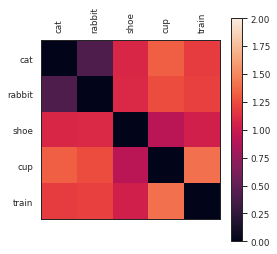

In [138]:
W_RDM = get_and_plot_RDM(WM_subset, WF_subset, 'kid',sort_inds,6,'workingmemory')

<Figure size 2160x2160 with 0 Axes>

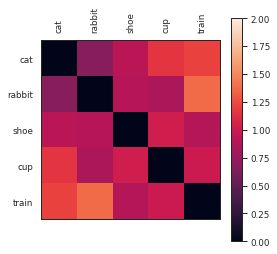

In [139]:
P_RDM = get_and_plot_RDM(PM_subset, PF_subset, 'kid',sort_inds,6,'perception')

###  Now let's break down by each age category

In [140]:
ind = KM.index[KM['condition'] == 'S']
SM_subset =  KM.loc[ind]
SF_subset =  KF[ind.tolist()]
print 'we have {} drawings in semantic condition'.format(np.shape(SM_subset)[0])

ind2 = KM.index[KM['condition'] == 'W']
WM_subset =  KM.loc[ind2]
WF_subset =  KF[ind2.tolist()]
print 'we have {} drawings in wm condition'.format(np.shape(WF_subset)[0])

ind3 = KM.index[KM['condition'] == 'P']
PM_subset =  KM.loc[ind3]
PF_subset =  KF[ind3.tolist()]
print 'we have {} drawings in perception condition'.format(np.shape(PF_subset)[0])

we have 94 drawings in semantic condition
we have 100 drawings in wm condition
we have 95 drawings in perception condition


<Figure size 2160x2160 with 0 Axes>

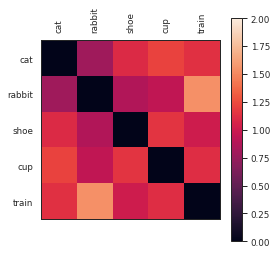

In [141]:
P_older_meta, P_older_features = subset_drawings(KM,KF,'older','P')
P_older_RDM = get_and_plot_RDM(P_older_meta, P_older_features, 'older_kid',sort_inds,6,'perception')

<Figure size 2160x2160 with 0 Axes>

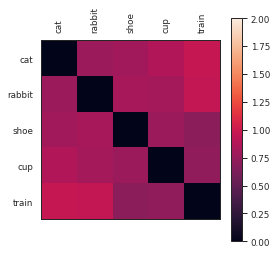

In [142]:
P_younger_meta, P_younger_features = subset_drawings(KM,KF,'younger','P')
P_younger_RDM = get_and_plot_RDM(P_younger_meta, P_younger_features, 'younger_kid',sort_inds,6,'perception')

<Figure size 2160x2160 with 0 Axes>

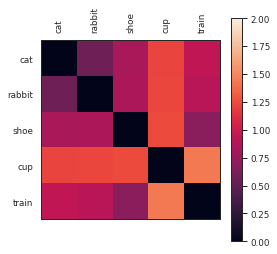

In [151]:
W_older_meta, W_older_features = subset_drawings(KM,KF,'older','W')
W_older_RDM = get_and_plot_RDM(W_older_meta, W_older_features, 'older_kid',sort_inds,6,'workingmemory')

<Figure size 2160x2160 with 0 Axes>

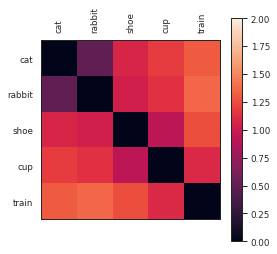

In [144]:
W_younger_meta, W_younger_features = subset_drawings(KM,KF,'younger','W')
W_younger_RDM = get_and_plot_RDM(W_younger_meta, W_younger_features, 'younger_kid',sort_inds,6,'workingmemory')

<Figure size 2160x2160 with 0 Axes>

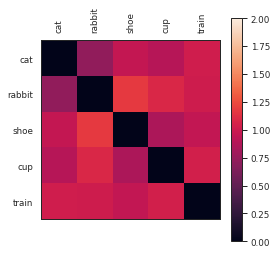

In [152]:
S_older_meta, S_older_features = subset_drawings(KM,KF,'older','S')
S_older_RDM = get_and_plot_RDM(S_older_meta, S_older_features, 'older_kid',sort_inds,6,'semantic')

<Figure size 2160x2160 with 0 Axes>

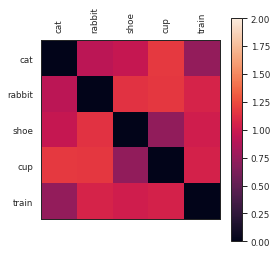

In [153]:
S_younger_meta, S_younger_features = subset_drawings(KM,KF,'younger','S')
S_younger_RDM = get_and_plot_RDM(S_younger_meta, S_younger_features, 'younger_kid',sort_inds,6,'semantic')

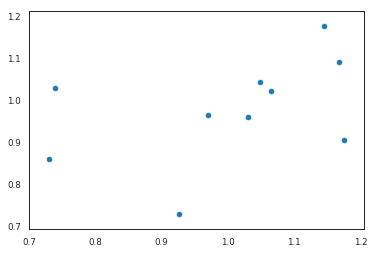

In [148]:
def compareRDMs(rdm_older,rdm_younger,num_categories):
    rdm_older_vector = np.ravel(rdm_older[np.triu_indices(5,k=1)])
    rdm_younger_vector = np.ravel(rdm_younger[np.triu_indices(5,k=1)])
#     corr = stats.spearmanr(rdm_older_vector,rdm_younger_vector)[0]
    plt.scatter(rdm_older_vector, rdm_younger_vector)
    return corr

S_younger_older_corr = compareRDMs(S_younger_RDM,S_older_RDM,5)

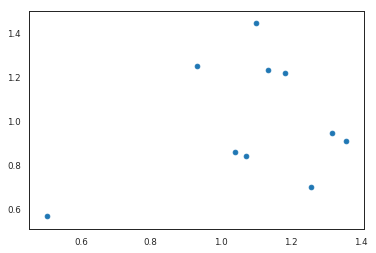

In [149]:
W_younger_older_corr = compareRDMs(W_younger_RDM,W_older_RDM,5)

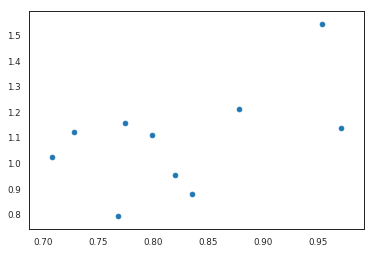

In [150]:
P_younger_older_corr = compareRDMs(P_younger_RDM,P_older_RDM,5)